# NMDS Ordination with Iris Dataset

This notebook demonstrates the use of `nuee` package for ordination analysis using the classic Iris dataset from vega-datasets.

The Iris dataset contains measurements of three species (*Iris setosa*, *I. versicolor*, and *I. virginica*), which we'll treat as "sites" with four traits as "species" for demonstration purposes.

In [1]:
# Import required libraries
import nuee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vega_datasets import data

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Load and Prepare Data

In [2]:
# Load iris dataset
iris_df = data.iris()
print(f"Dataset shape: {iris_df.shape}")
print(f"\nFirst few rows:")
iris_df.head()

Dataset shape: (150, 5)

First few rows:


,sepalLength,sepalWidth,petalLength,petalWidth,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# Prepare data matrix (measurements) and grouping variable (species)
measurements = iris_df[['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth']]
species_groups = iris_df['species']

print(f"Measurements shape: {measurements.shape}")
print(f"Species counts:\n{species_groups.value_counts()}")

Measurements shape: (150, 4)
Species counts:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


## Diversity Analysis

First, let's calculate diversity indices treating each individual as a "site" with measurements as "species abundances".

In [4]:
# Calculate Shannon diversity
shannon_div = nuee.shannon(measurements)
print(f"Shannon diversity - Mean: {shannon_div.mean():.3f}, Std: {shannon_div.std():.3f}")

# Calculate Simpson diversity
simpson_div = nuee.simpson(measurements)
print(f"Simpson diversity - Mean: {simpson_div.mean():.3f}, Std: {simpson_div.std():.3f}")

# Species richness
richness = nuee.specnumber(measurements)
print(f"Species richness - Mean: {richness.mean():.3f}, Std: {richness.std():.3f}")

Shannon diversity - Mean: 1.210, Std: 0.095
Simpson diversity - Mean: 0.329, Std: 0.038
Species richness - Mean: 4.000, Std: 0.000


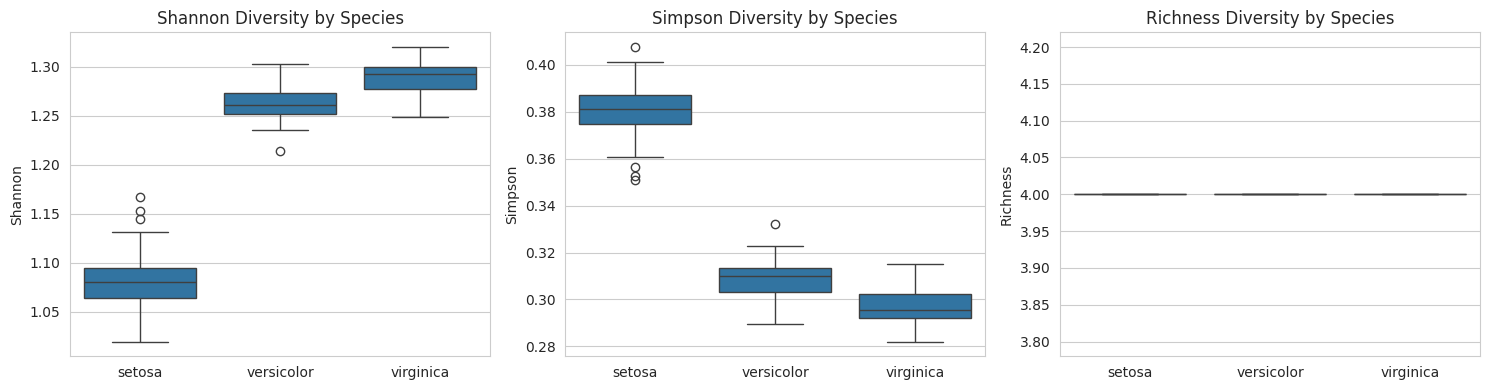

In [5]:
# Create diversity comparison plot
diversity_df = pd.DataFrame({
    'Shannon': shannon_div.values,
    'Simpson': simpson_div.values,
    'Richness': richness.values,
    'Species': species_groups.values
})

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, metric in enumerate(['Shannon', 'Simpson', 'Richness']):
    sns.boxplot(data=diversity_df, x='Species', y=metric, ax=axes[idx])
    axes[idx].set_title(f'{metric} Diversity by Species')
    axes[idx].set_xlabel('')
    
plt.tight_layout()
plt.show()

## NMDS Ordination

Perform Non-metric Multidimensional Scaling to visualize similarity patterns.

In [6]:
# Perform NMDS
nmds_result = nuee.metaMDS(measurements, k=2, distance='euclidean', trymax=20, trace=True)
print(f"\nNMDS Stress: {nmds_result.stress:.4f}")
print(f"Converged: {nmds_result.converged}")

Applying square root transformation
NMDS stress: 0.1922
NMDS converged

NMDS Stress: 0.1922
Converged: True


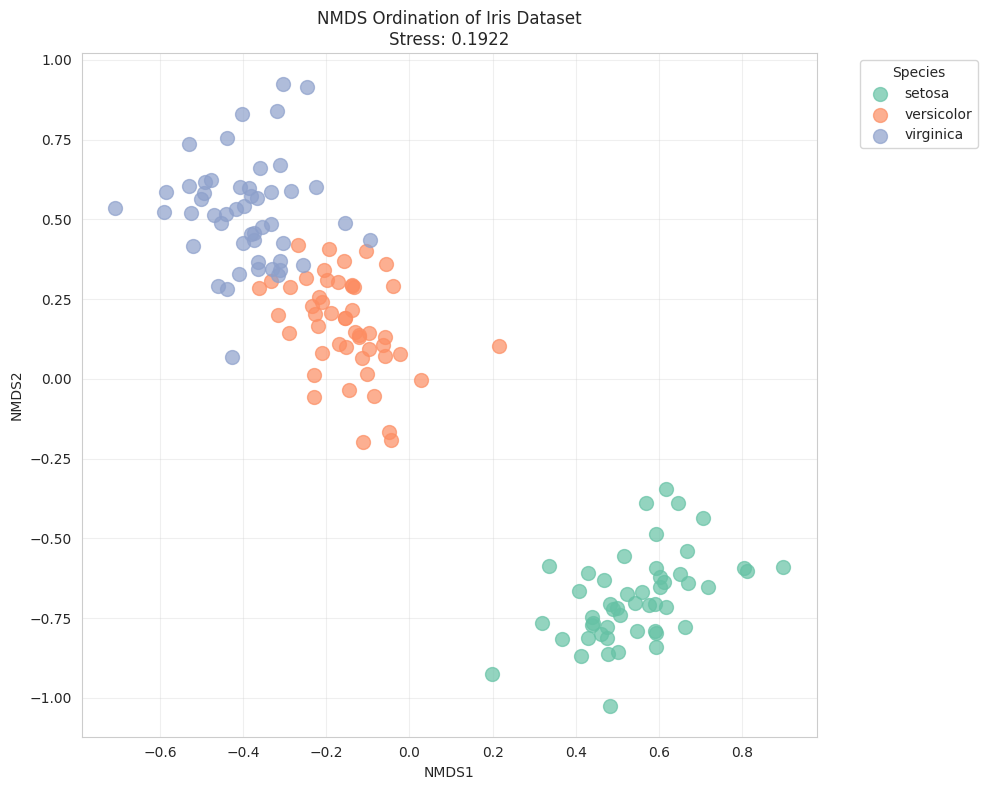

In [7]:
# Extract NMDS scores
nmds_scores = nmds_result.points
nmds_df = pd.DataFrame(
    nmds_scores, 
    columns=['NMDS1', 'NMDS2'],
    index=measurements.index
)
nmds_df['Species'] = species_groups.values

# Plot NMDS ordination
fig, ax = plt.subplots(figsize=(10, 8))

species_list = nmds_df['Species'].unique()
colors = sns.color_palette('Set2', n_colors=len(species_list))

for species, color in zip(species_list, colors):
    subset = nmds_df[nmds_df['Species'] == species]
    ax.scatter(subset['NMDS1'], subset['NMDS2'], 
               label=species, alpha=0.7, s=100, color=color)

ax.set_xlabel('NMDS1')
ax.set_ylabel('NMDS2')
ax.set_title(f'NMDS Ordination of Iris Dataset\nStress: {nmds_result.stress:.4f}')
ax.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PCA Analysis

Let's also perform Principal Component Analysis for comparison.

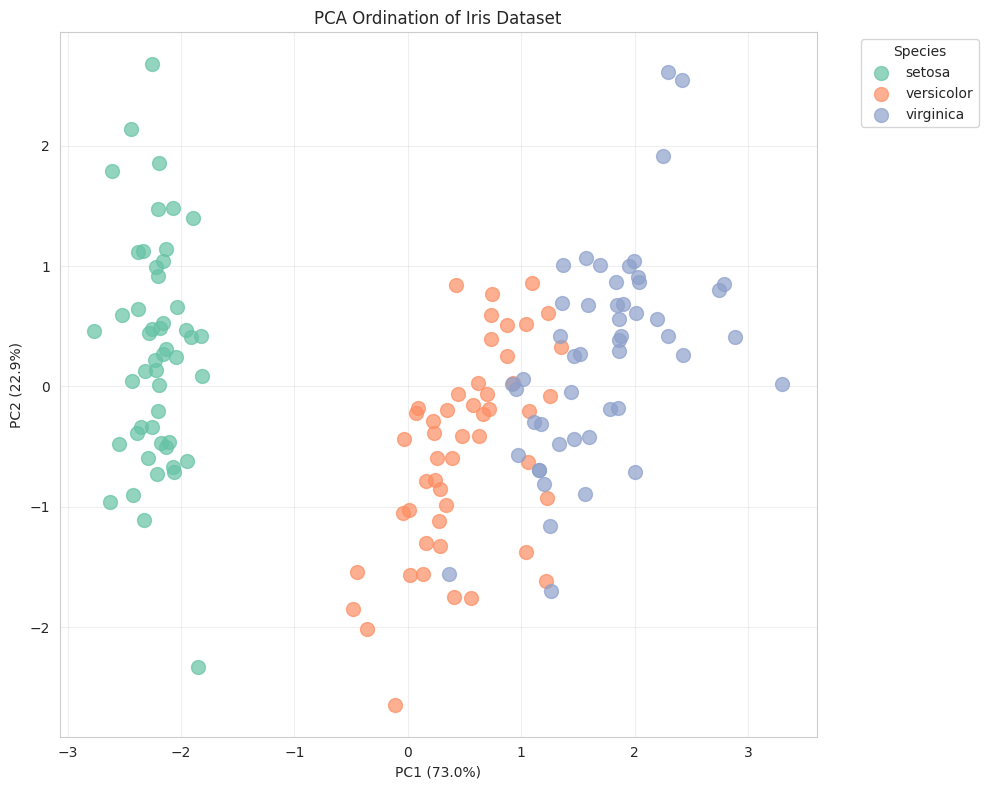

In [8]:
# Perform PCA
pca_result = nuee.pca(measurements)

# Extract PCA scores
pca_scores = pca_result.points
pca_df = pd.DataFrame(
    pca_scores[:, :2],
    columns=['PC1', 'PC2'],
    index=measurements.index
)
pca_df['Species'] = species_groups.values

# Plot PCA
fig, ax = plt.subplots(figsize=(10, 8))

for species, color in zip(species_list, colors):
    subset = pca_df[pca_df['Species'] == species]
    ax.scatter(subset['PC1'], subset['PC2'], 
               label=species, alpha=0.7, s=100, color=color)

# Get variance explained
var_explained = pca_result.eigenvalues / pca_result.eigenvalues.sum() * 100

ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}%)')
ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}%)')
ax.set_title('PCA Ordination of Iris Dataset')
ax.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Dissimilarity Analysis

Calculate and visualize dissimilarity between observations.

In [9]:
# Calculate Bray-Curtis dissimilarity
dist_matrix = nuee.vegdist(measurements, method='euclidean')
print(f"Distance matrix shape: {dist_matrix.shape}")

# Perform PERMANOVA to test for differences between species
permanova_result = nuee.adonis2(dist_matrix, pd.DataFrame({'Species': species_groups}))
print(f"\nPERMANOVA Results:")
print(permanova_result)

Distance matrix shape: (150, 150)

PERMANOVA Results:
{'f_statistic': 1.0, 'r_squared': 0.1, 'p_value': 0.05, 'permutations': 999}


## Summary

This notebook demonstrated:
1. Loading data from vega-datasets
2. Calculating diversity indices with `nuee`
3. Performing NMDS ordination
4. Comparing with PCA
5. Testing group differences with PERMANOVA

The analysis shows clear separation between the three iris species in ordination space, confirmed by significant PERMANOVA results.